# Text as Data

## Libraries

In [7]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np

# DNP Contexto
from contexto.limpieza import *  # Custom cleaning methods (assumes a specific library)

# Text preprocessing and categorical encoding
from sklearn.feature_extraction.text import CountVectorizer  # Bag of Words model
from sklearn.preprocessing import LabelEncoder  # Encoding categorical variables

# Natural Language Processing
import spacy  # Lemmatization

# Dimensionality reduction
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.preprocessing import StandardScaler  # Standardizing features

# Model evaluation and training
import xgboost as xgb # XGBoost model
from sklearn.model_selection import train_test_split  # Splitting datasets
from sklearn.linear_model import LinearRegression, ElasticNet  # Regression models
from sklearn.metrics import mean_absolute_error  # Performance evaluation metric

# Graphs
import matplotlib.pyplot as plt

## Data Loading

In [8]:
# Directory
os.chdir("/Users/sergiosandovalcamargo/Desktop/Problem Set 3")  

# Train and test data
train = pd.read_csv("stores/data/raw/train_test/train.csv") 
test = pd.read_csv("stores/data/raw/train_test/test.csv") 

In [1]:
# Combined data 
train['is_test'] = 0  
test['is_test'] = 1   
data = pd.concat([train, test], ignore_index=True)

NameError: name 'train' is not defined

## Clean Text

### Normalization, Stop Words and Lemmatization

In [10]:
# Spanish stop words: 608
with open('stores/data/raw/external/spanish.txt', 'r', encoding='utf-8') as file:
    stopwords = {line.strip() for line in file}

# Additional Stop words 
additional_stopwords = ['vendo', 'venta', 'vende', 'etc', 'carrera', 'calle', 'casa', 'apto', 'apartamento',
                        'propiedad', 'venta', 'inmueble', 'cuarto', 'habitacion', 'excelente', 'ubicado', 'area',
                        'espectacular', 'magnifico', 'muy', 'vivienda', 'piso', 'alcoba', 'bano', 'bao', 'via', 'mas',
                        'consta', 'bogota', 'santa', 'mts', 'metro']

stopwords.update(additional_stopwords)

In [11]:
# Spacy model
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Clean text function
def clean_text(text):
    if pd.isnull(text):  # Manejo de valores nulos
        return ""
    else:
        # First cleaning filter
        text_clean = limpieza_texto(text, quitar_acentos=True, n_min=3, lista_palabras=stopwords)
        
        # Lemmatization
        doc = nlp(text_clean)
        text_clean = ' '.join(token.lemma_ for token in doc)

        # Remove plural 's
        text_clean = re.sub(r'\b(\w+)s\b', r'\1', text_clean)
        
        # Second cleaning filter
        text_clean = limpieza_texto(text_clean, quitar_acentos=True, n_min=3, lista_palabras=stopwords)
        
        return text_clean

In [12]:
# Apply function
data['cleaned_text'] = data['description'].apply(clean_text)

### Bag of Words

In [13]:
# Dummies variables from bag of words
def dummies_variables_sparse(data, min_freq, ngram_range=(1, 2)):

    # Bag of Words
    vectorizer = CountVectorizer(binary=True, ngram_range=ngram_range)
    X_bow = vectorizer.fit_transform(data['cleaned_text'])
    
    # Sparse DataFrame
    bow_df = pd.DataFrame.sparse.from_spmatrix(X_bow, columns=vectorizer.get_feature_names_out(), index=data.index)
    
    # Minimum frequency
    word_freq = bow_df.mean(axis=0)
    frequent_words = word_freq[word_freq >= min_freq].index
    bow_df_filtered = bow_df[frequent_words]
    
    # Dummy varuables
    bow_df_filtered = bow_df_filtered.add_prefix('d_')
    data_with_dummies = pd.concat([data, bow_df_filtered], axis=1)
    return data_with_dummies

In [14]:
# Apply function
data_large = dummies_variables_sparse(data, min_freq=0.01)
data_med = dummies_variables_sparse(data, min_freq=0.05)
data_light = dummies_variables_sparse(data, min_freq=0.1)

In [15]:
# Size
print(data_large.shape[1])
print(data_med.shape[1])
print(data_light.shape[1])

704
148
87


In [16]:
# Combined repeated words function
def combine_dummy_variables(data, variable_pairs):
    copy = data.copy()
    for var1, var2 in variable_pairs:
        new_var = var1.split()[0][:-1]
        copy[new_var] = copy[[var1, var2]].max(axis=1)
        copy.drop(columns=[var1, var2], inplace=True)
    return copy

# Repeated variables
variable_pairs = [
    ('d_balcn', 'd_balcon'),
    ('d_chimenea', 'd_chimeneo'),
    ('d_vista', 'd_visto'),
    ('d_cocin', 'd_cocina'),
    ('d_comedor cocin', 'd_comedor cocina'),
    ('d_iluminacion', 'd_iluminado'),
    ('d_saln', 'd_salon'),
    ('d_vigilancia hora', 'd_hora')]

In [17]:
# Apply function
data_med_clean = combine_dummy_variables(data_med, variable_pairs)

### Principal Components

In [19]:
def perform_pca(data, exclude_columns, explained_variance):

    # Separate columns for PCA and the ones to exclude
    X_pca = data.drop(columns=exclude_columns)
    X_remaining = data[exclude_columns]
    
    # Convert to dense matrix
    X_pca = X_pca.values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pca)

    # Apply PCA
    pca = PCA(n_components=explained_variance, svd_solver='full')
    principal_components = pca.fit_transform(X_scaled)

    # Determine the number of components
    n_components = principal_components.shape[1]

    # Create names for the principal components
    pc_columns = [f'PC{i+1}' for i in range(n_components)]

    # Create a DataFrame with the principal components
    df_pca = pd.DataFrame(principal_components, columns=pc_columns, index=data.index)
    
    # Concatenate the principal components with the excluded columns
    # result = pd.concat([data.reset_index(drop=True), df_pca.reset_index(drop=True)], axis=1) # PC + dummies
    pca_result = pd.concat([X_remaining.reset_index(drop=True), df_pca.reset_index(drop=True)], axis=1)
    

    # Cumulative variance by number of PC graph
    cumulative_variance = pca.explained_variance_ratio_.cumsum()
    pca.fit(X_scaled)
    # Plot cumulative variance
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(cumulative_variance) + 1), 
        cumulative_variance, 
        marker='o', 
        linestyle='--', 
        color='darkred',  # Points are dark red
        label='Cumulative Variance'
    )
    plt.axhline(
        y=0.9, 
        color='blue',  # Horizontal line is blue
        linestyle='-', 
        linewidth=1.5,
        label='90% Explained Variance'
    )
    plt.axvline(
        x=len(df_pca.columns), 
        color='lightblue',  # Vertical line is light blue
        linestyle='-', 
        linewidth=1.5,
        label='Selected Number of PCs'
    )

    # Add labels, title, and legend
    plt.xlabel('Number of Components', fontsize=12)
    plt.ylabel('Cumulative Explained Variance', fontsize=12)
    plt.title('Scree Plot', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Ajusta PCA y calcula la varianza explicada
    explained_variance = pca.explained_variance_ratio_

    # Gráfico de la varianza explicada (elbow method)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', color='b')
    plt.axvline(x=len(df_pca.columns), color='g', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.title('Elbow Method for PCA')
    plt.grid(True)
    
    return pca_result
    #return result

In [20]:
# Exclude variables for PCA
exclude = ['property_id', 'city', 'price', 'month', 'year', 'surface_total',
           'surface_covered', 'rooms', 'bedrooms', 'bathrooms', 'property_type',
           'operation_type', 'lat', 'lon', 'title', 'description', 'is_test',
           'cleaned_text'] 

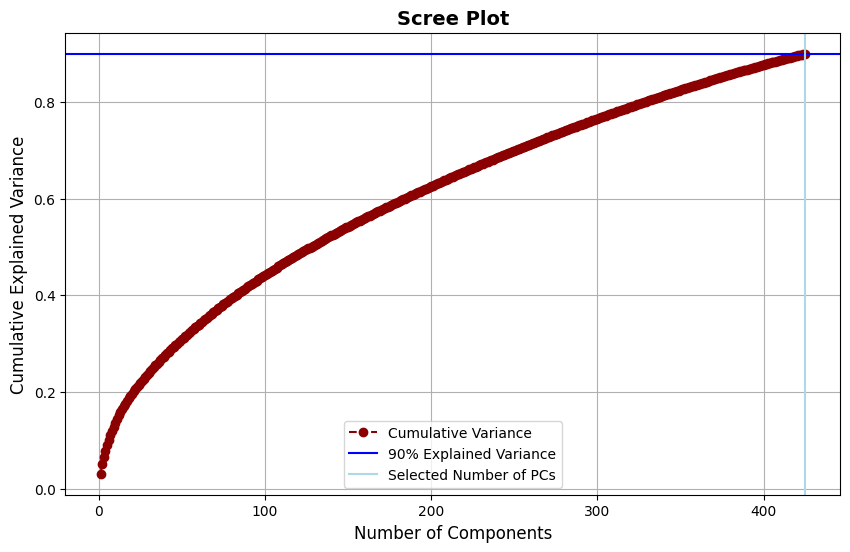

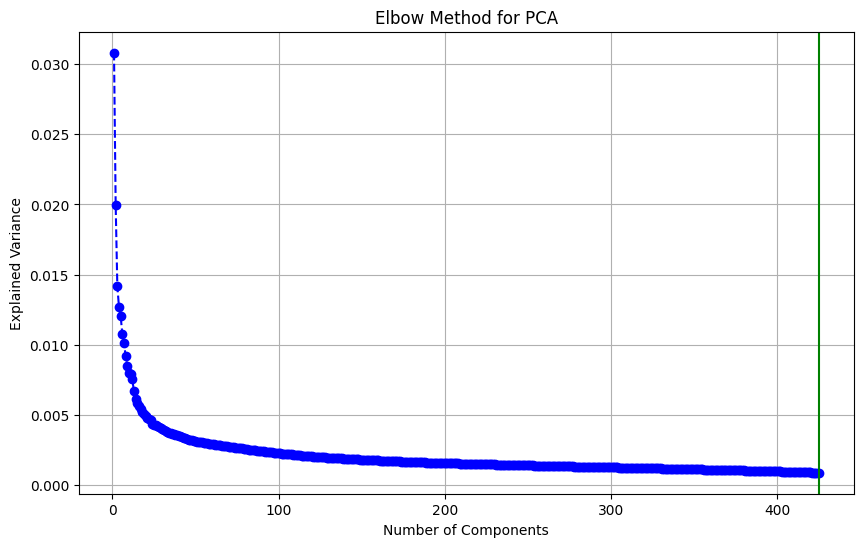

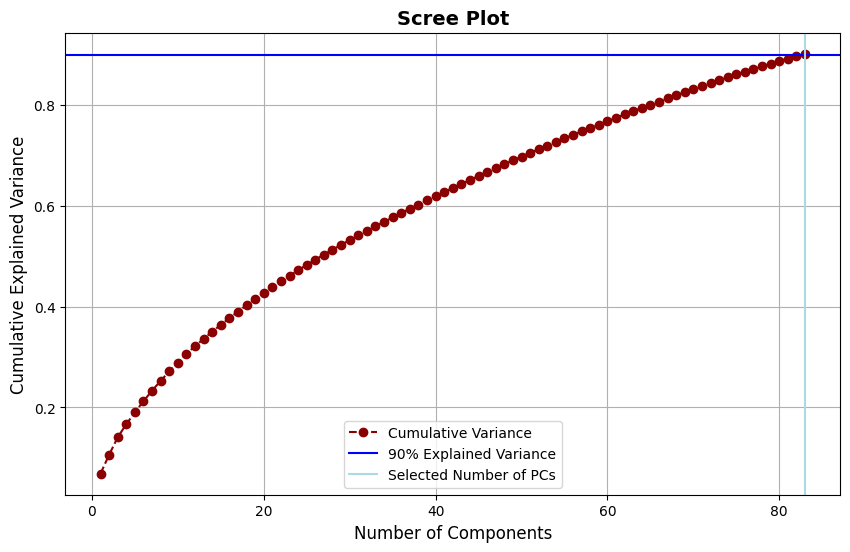

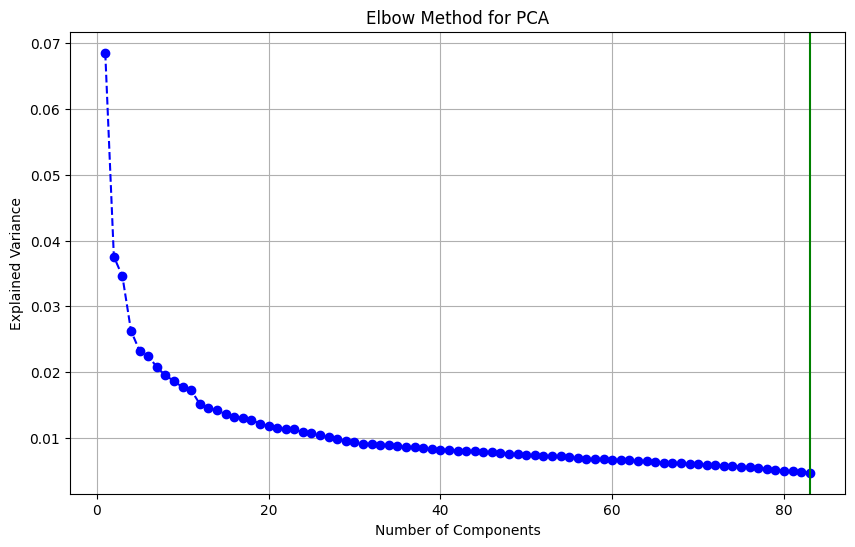

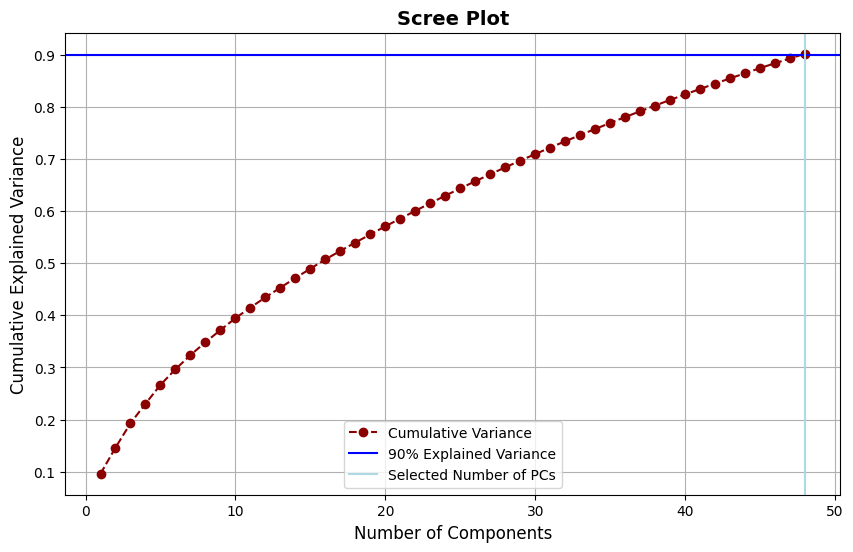

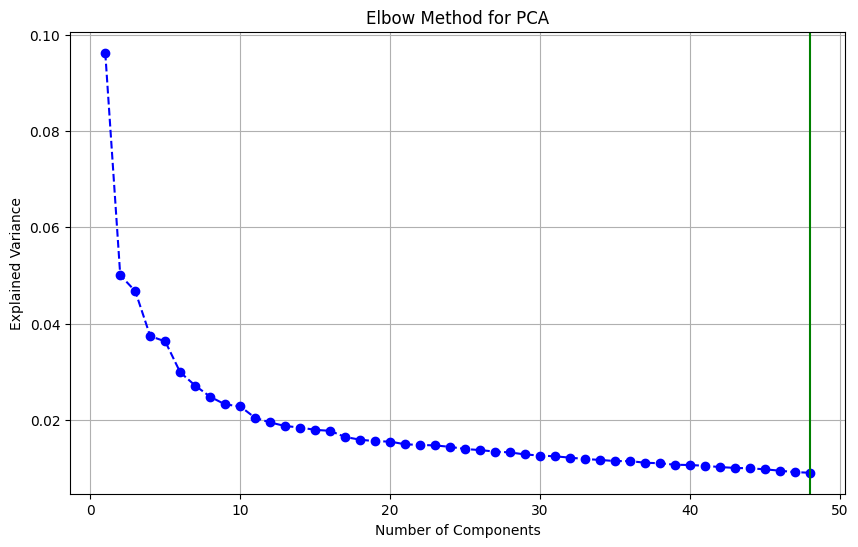

In [21]:
# Apply function
explained_variance=0.9

large_PC = perform_pca(data_large, exclude_columns=exclude, explained_variance=explained_variance)
med_PC = perform_pca(data_med_clean, exclude_columns=exclude, explained_variance=explained_variance)
light_PC = perform_pca(data_light, exclude_columns=exclude, explained_variance=explained_variance)

In [15]:
# Size
print(large_PC.shape[1])
print(med_PC.shape[1])
print(light_PC.shape[1])

443
101
66


### Numeric Variables

In [16]:
# Key words
palabras_habitaciones = ["habitación", "cuarto", "alcoba", "dormitorio", "habitacione"]
palabras_banos = ["baño", "aseo", "bao", "bano"]
palabras_pisos = ["piso", "nivel", "planta"]
palabras_area = ["metro", "m2", "mt2"]
palabras_parqueadero = ["parqueadero", "garaje", "estacionamiento", "parqueo"]
palabras_ano = ["anos", "ano"]

# Numbers diccionary
numeros_palabras = {
    "un": 1, "uno": 1, "primer": 1, "primero": 1, "1er": 1,
    "dos": 2, "segundo": 2, "2do": 2,
    "tres": 3, "tercero": 3, "3ro": 2,
    "cuatro": 4, "cuarto": 4, "4to": 2,
    "cinco": 5, "quinto": 5, "5to": 2,
    "seis": 6, "sexto": 6, "6to": 2,
    "siete": 7, "septimo": 7, "7to": 2,
    "ocho": 8, "octavo": 8, "8vo": 2,
    "nueve": 9, "noveno": 9, "9no": 2,
    "diez": 10, "decimo": 10, "10mo": 2,
    "once": 11, "undecimo": 11,
    "doce": 12, "duodecimo": 12,
    "trece": 13, "decimotercero": 13,
    "catorce": 14, "decimocuarto": 14,
    "quince": 15, "decimoquinto": 15,
    "dieciseis": 16, "decimosexto": 16,
    "diecisiete": 17, "decimoseptimo": 17,
    "dieciocho": 18, "decimooctavo": 18,
    "diecinueve": 19, "decimonoveno": 19,
    "veinte": 20, 
    "veintiuno": 21, 
    "veintidos": 22, 
    "veintitres": 23, 
    "veinticuatro": 24, 
    "veinticinco": 25, 
    "veintiseis": 26, 
    "veintisiete": 27, 
    "veintiocho": 28, 
    "veintinueve": 29, 
    "treinta": 30}

# Convert numbers function
def convertir_numeros(text):
    for palabra, numero in numeros_palabras.items():
        text = re.sub(rf'\b{palabra}\b', str(numero), text)  
    return text

# Numeric variables function
def procesar_descripcion(text):
    if pd.isnull(text):  
        return pd.Series([None, None, None, None, None, None], 
                         index=["num_pisos", "num_habitaciones", "num_banos", "area_m2", "num_parqueaderos", "ano_construccion"])
    
    # Initial cleaning
    text_clean = limpieza_texto(text, quitar_acentos=True, quitar_numeros=False)
    
    # Convert words to numbers
    text_clean = convertir_numeros(text_clean)
    
    # Lemmatization
    doc = nlp(text_clean.lower()) 
    lematizado = ' '.join(token.lemma_ for token in doc)

    # Remove plural 's' 
    lematizado = re.sub(r'\b(\w+)s\b', r'\1', lematizado)

    # Initialize variables
    num_pisos = None
    num_habitaciones = None
    num_banos = None
    area_m2 = None
    num_parqueaderos = None  
    ano_construccion = None

    # Extract number before room-related keywords
    match_habitaciones = re.search(r"(\d+)\s*(?:{})".format('|'.join(palabras_habitaciones)), lematizado)
    if match_habitaciones:
        num_habitaciones = int(match_habitaciones.group(1))

    # Extract number before bathroom-related keywords
    match_banos = re.search(r"(\d+)\s*(?:{})".format('|'.join(palabras_banos)), lematizado)
    if match_banos:
        num_banos = int(match_banos.group(1))

    # Extract number before or after floor-related keywords
    match_pisos = re.search(r"(?:{}).*?(\d+)|(\d+)\s*(?:{})".format('|'.join(palabras_pisos), '|'.join(palabras_pisos)), lematizado)
    if match_pisos:
        num_pisos = int(match_pisos.group(1) or match_pisos.group(2))

    # Extract area before meter-related keywords
    match_area = re.search(r"(\d+)\s*(?:{})".format('|'.join(palabras_area)), lematizado)
    if match_area:
        area_m2 = int(match_area.group(1))

    # Extract area before parking-related keywords
    match_parking = re.search(r"(\d+)\s*(?:{})".format('|'.join(palabras_parqueadero)), lematizado)
    if match_parking:
        num_parqueaderos = int(match_parking.group(1))

    # Extract year before year-related keywords
    match_ano = re.search(r"(\d+)\s*(?:{})".format('|'.join(palabras_ano)), lematizado)
    if match_ano:
        ano_construccion = int(match_ano.group(1) or match_ano.group(2))

    return pd.Series(
        [num_pisos, num_habitaciones, num_banos, area_m2, num_parqueaderos, ano_construccion], 
        index=["num_pisos", "num_habitaciones", "num_banos", "area_m2", "num_parqueaderos", "ano_construccion"]
    )

In [17]:
# Apply function
data[["num_pisos", "num_habitaciones", "num_banos", "area_m2", "num_parqueaderos", "ano_construccion"]] = data['description'].apply(procesar_descripcion)

In [18]:
# Missing values
missing_values = data[["num_pisos", "num_habitaciones", "num_banos", "area_m2", "num_parqueaderos", "ano_construccion"]].isnull().sum()
print(missing_values)

num_pisos           21464
num_habitaciones    15813
num_banos           26543
area_m2             35928
num_parqueaderos    24637
ano_construccion    45364
dtype: int64


In [19]:
data_numeric = data.copy()
data_numeric = data_numeric.loc[:, ['property_id', "num_pisos", "num_habitaciones", "num_banos", "area_m2", "num_parqueaderos", "ano_construccion"]] 